# Export universe
* Export from Database
* Calculate x, y and z position

In [1]:
import pandas as pd
import mysql.connector
from pathlib import Path
import math
import random
import json

## Define the Unvierse

In [12]:
universe_r = 1050000000
#universe_r = 10000
universe_circles = 12

## Connect to Database

In [13]:
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="",
    database = "pharmagelder"
)

## Download Planets

In [14]:
df_planets = pd.read_sql("""
    SELECT
      pha_id,
      pha_name,
      sum(value) as value
    FROM view_transaction_union
    LEFT JOIN pharma ON fk_pharma = pha_id
    GROUP BY fk_pharma;
""", con=db_connection)

In [15]:
df_planets['value'] = round(df_planets['value'])

In [16]:
len(df_planets)

68

<AxesSubplot:>

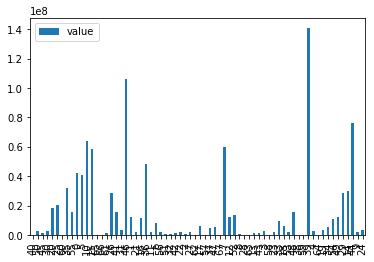

In [17]:
# Reorder Planets
df_planets = df_planets.sort_values('value', ascending=False)
df_planets['i'] = df_planets.index % 5

df_planets = df_planets.sort_values('i')
df_planets[['value']].plot.bar()


In [18]:
# Calc sizes
plMin = 500000
plMax  = 25000000
phMin = df_planets['value'].min()
phMax = df_planets['value'].max()
plDist = plMax - plMin
phDist = phMax - phMin

planets = []

n = len(df_planets)
for i, row in df_planets.iterrows():
    
    y = math.floor(math.floor((i + 1) / (n / universe_circles))) * (universe_r / universe_circles) + (universe_r / universe_circles) / 2
    #h = y <= (universe_r / 2) ? y : universe_r - y
    h = y if y <= (universe_r / 2) else universe_r - y

    r_new = math.sqrt(abs(2 * universe_r * h - math.pow(h, 2)))

    items = n / universe_circles

    step = math.pi * 2 / items
    angle = (i % items) * step
    x = r_new * math.cos(angle)
    z = r_new * math.sin(angle)
    
    x = round(x)
    y = round(y)
    z = round(z)
    
    df_planets.loc[i, 'x'] = x
    df_planets.loc[i, 'y'] = y
    df_planets.loc[i, 'z'] = z
    
    # Calc Size
    prozPh = 100 / phDist * row['value']
    size = round(plDist / 100 * prozPh + plMin)
    df_planets.loc[i, 'size'] = size
    
    planets.append({
        'x': x,
        'y': y,
        'z': z,
        'id': row['pha_id'],
        'name': row['pha_name'],
        'value': row['value'],
        'size': size
    })

## Download Asteroids

In [19]:
df_asteroids = pd.read_sql("""
   SELECT 
     tra_fk_recipient as recipient,
     tra_fk_pharma as pharma,
     sum(tra_value) as value
     FROM 
       transaction
     GROUP BY tra_fk_recipient, tra_fk_pharma;
""", con=db_connection)

In [20]:
len(df_asteroids)

34517

In [93]:
asteroids = []

for rec in df_asteroids.recipient.unique():
    df = df_asteroids[df_asteroids.recipient == rec]
    
    x = 0
    y = 0
    z = 0
    d = 0
    
    
    if len(df) == 1:
        # Its a Moon: Single Giver
        plan = df_planets[df_planets.pha_id == df.iloc[0]['pharma']].iloc[0]
        size = plan['size'] * 8
        
        angle_s = random.uniform(0,math.pi * 2)
        angle_t = random.uniform(0,math.pi)    
        
        x = plan['x'] + size * math.cos(angle_s) * math.sin(angle_t)
        y = plan['y'] + size * math.sin(angle_s) * math.sin(angle_t)
        z = plan['z'] + size * math.cos(angle_t)

        d = df.iloc[0]['value']

        astertyp = 'moon'
        
    else:
        # Its an asteroid: More than one Giver

        for pha, row in df.iterrows():
            plan = df_planets[df_planets.pha_id == row['pharma']].iloc[0]
            x += (row['value'] * plan['x'])
            y += (row['value'] * plan['y'])
            z += (row['value'] * plan['z'])
            d = d + row['value']
            astertyp = 'asteroid'
        
        x = x / d
        y = y / d
        z = z / d
    
    asteroids.append({
        'id': int(rec),
        'value': df['value'].sum(),
        'x': round(x),
        'y': round(y),
        'z': round(z),
        'type': astertyp
    })

In [94]:
len(asteroids)

15991

## Save file

In [95]:
with open(Path('../../client/src/data.js'), 'w') as f:
    f.write('exports.planets = %s\n\nexports.asteroids = %s\n\nexports.solarsystem_r = %s' % (json.dumps(planets), json.dumps(asteroids), universe_r))
    #f.write('exports.planets = %s\n\nexports.solarsystem_r = %s' % (json.dumps(planets), universe_r))